[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)]()

In [1]:
from __future__ import division
import time
import os
import copy
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt

print("PyTorch Version: ",torch.__version__)
print("Torchvision Version: ",torchvision.__version__)

PyTorch Version:  1.7.1
Torchvision Version:  0.8.2


In [1]:
#Download dataset :  !wget https://download.pytorch.org/tutorial/hymenoptera_data.zip

In [2]:
data_dir = "./data"
model_name = "vgg"
# Number of classes in the dataset
num_classes = 2
name_classes = {1 : 'Bees', 0:'Ants'}

In [142]:
# Importing models 
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

## Model : VGG11 
model_ft = models.vgg11_bn(pretrained=True).to(device)

## Don't compute grad of params
for param in model_ft.parameters():
    param.requires_grad = False

    
num_ftrs = model_ft.classifier[6].in_features
# Force out features to two classes : we have ants and bees
model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
input_size = 224

In [7]:
# import data
data_transforms = {
    'val': transforms.Compose([
        transforms.Resize(input_size),
        transforms.CenterCrop(input_size),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

# Create training and validation datasets
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in [ 'val']}

testloader = torch.utils.data.DataLoader(image_datasets['val'], 
                                         batch_size=1, 
                                         shuffle=True, 
                                         num_workers=4)

In [232]:
for d, t in testloader :
    data , target = d ,t 
    break

In [66]:
def target_adversarial(model,x_target, device, n=0,epochs = 200,eta=0.5, lmd=0.05):
    """
   Function to generate an adversarial exemple based on a model, a target image and a label. 
   We need to have access to the gradient of the parameters in the model. 
    ...

    Parameters
    ----------
    model : torch model
    x_target : torch tensor
        the name of the animal
    n : int
        the sound that the animal makes
    device : torch.device
        the number of legs the animal has (default 4)
    epochs : int
        the number of epochs for gradient descent
    eta : float
        learning rate for gradient descent
    lmd : float 
        hyperparameter for 
    
    Returns
    -------
    x : torch tensor
        adversarial exemple
    """
    # Set the goal output
    goal = torch.tensor([n]).to(device)
    #
    x = torch.randn(x_target.size()).to(device)
    x.requires_grad = True
    
    # Gradient descent on the input
    for epoch in range(epochs):
        output = model(x)
        criterion = nn.CrossEntropyLoss()
        loss = criterion(output, goal)
        model.zero_grad()
        # Backward pass
        loss.backward()
        # Get grad
        d = x.grad.data
        # The SGD update on x
        with torch.no_grad():
            # we don't need to update model params
            x -= eta * (d + lmd * (x - x_target)) 
            x.grad = None
    return x

In [ ]:
lmds =[0.01,0.1, 0.5,1]
fig, ax = plt.subplots(1,len(lmds),figsize=(20,10))

for i, lmd in enumerate(lmds) : 
    adv = target_adversarial(model_ft,d,device,n=0,lmd=lmd)
    label = model_ft(adv).max(1, keepdim=True)[1]
    adv = adv.squeeze().detach().cpu().permute(1, 2, 0)
    ax[i].imshow(adv)
    ax[i].set_title("Lamda = {}, Advs label : {}".format(lmd,name_classes[label.item()]))

Not a robust method : 
> The method can sometimes be defeated merely by degrading the image quality, for example, by rounding to an 8-bit representation of each pixel.

### Testing FGSM 

In [239]:
def fgsm_attack(image, epsilon, data_grad):
    #  Sign of the data gradient
    sign_data_grad = data_grad.sign()
    # Add grad *epsilon to pixel of the input image
    perturbed_image = image + epsilon*sign_data_grad
    # Clip to  [0,1] range
    perturbed_image = torch.clamp(perturbed_image, 0, 1)
    return perturbed_image

In [308]:
def generate_adv(model,testloader,epsilon):
    correct = 0
    adv_examples = []
    loop = tqdm(testloader)
    model.eval()
    for d, t in loop :
        data , target = d ,t 
        data.requires_grad = True
    
        output = model(data)
        init_pred = output.max(1, keepdim=True)[1] #index of the max log-probability
        
        if init_pred.item() != target.item():
            # Skip bad exemples in testdata
            continue            
        # Calculate negative log likelihood loss used
        loss = F.nll_loss(output, target) 
        model.zero_grad()
        # Backward pass
        loss.backward()
        
        ## FGSM Attack
        # Collect datagrad
        data_grad = data.grad.data
        perturbed_data = fgsm_attack(data, epsilon, data_grad)
        
        # Getting the label
        output = model(perturbed_data)
        final_pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
        if final_pred.item() == target.item(): # Nothing changed ( model has good defense)
             correct += 1
        else :
            # Save exemple 
            if len(adv_examples) < 5:
                adversary = perturbed_data.squeeze().detach().cpu().permute(1, 2, 0)
                original = data.squeeze().detach().cpu().permute(1, 2, 0)
                adv_examples.append((original, adversary, init_pred , final_pred))
    final_acc = correct / float(len(testloader))
    return adv_examples, final_acc 

In [291]:
accuracies = []
examples = []
epsilons =[0.1,0.3,0.5,0.7]

#Run test for each epsilon
for i , eps in enumerate(epsilons):
    adv_examples, final_acc  = generate_adv(model_ft,testloader,epsilon=eps)
    accuracies.append(final_acc)
    examples.append(adv_examples)    

100%|██████████| 153/153 [01:09<00:00,  2.20it/s]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


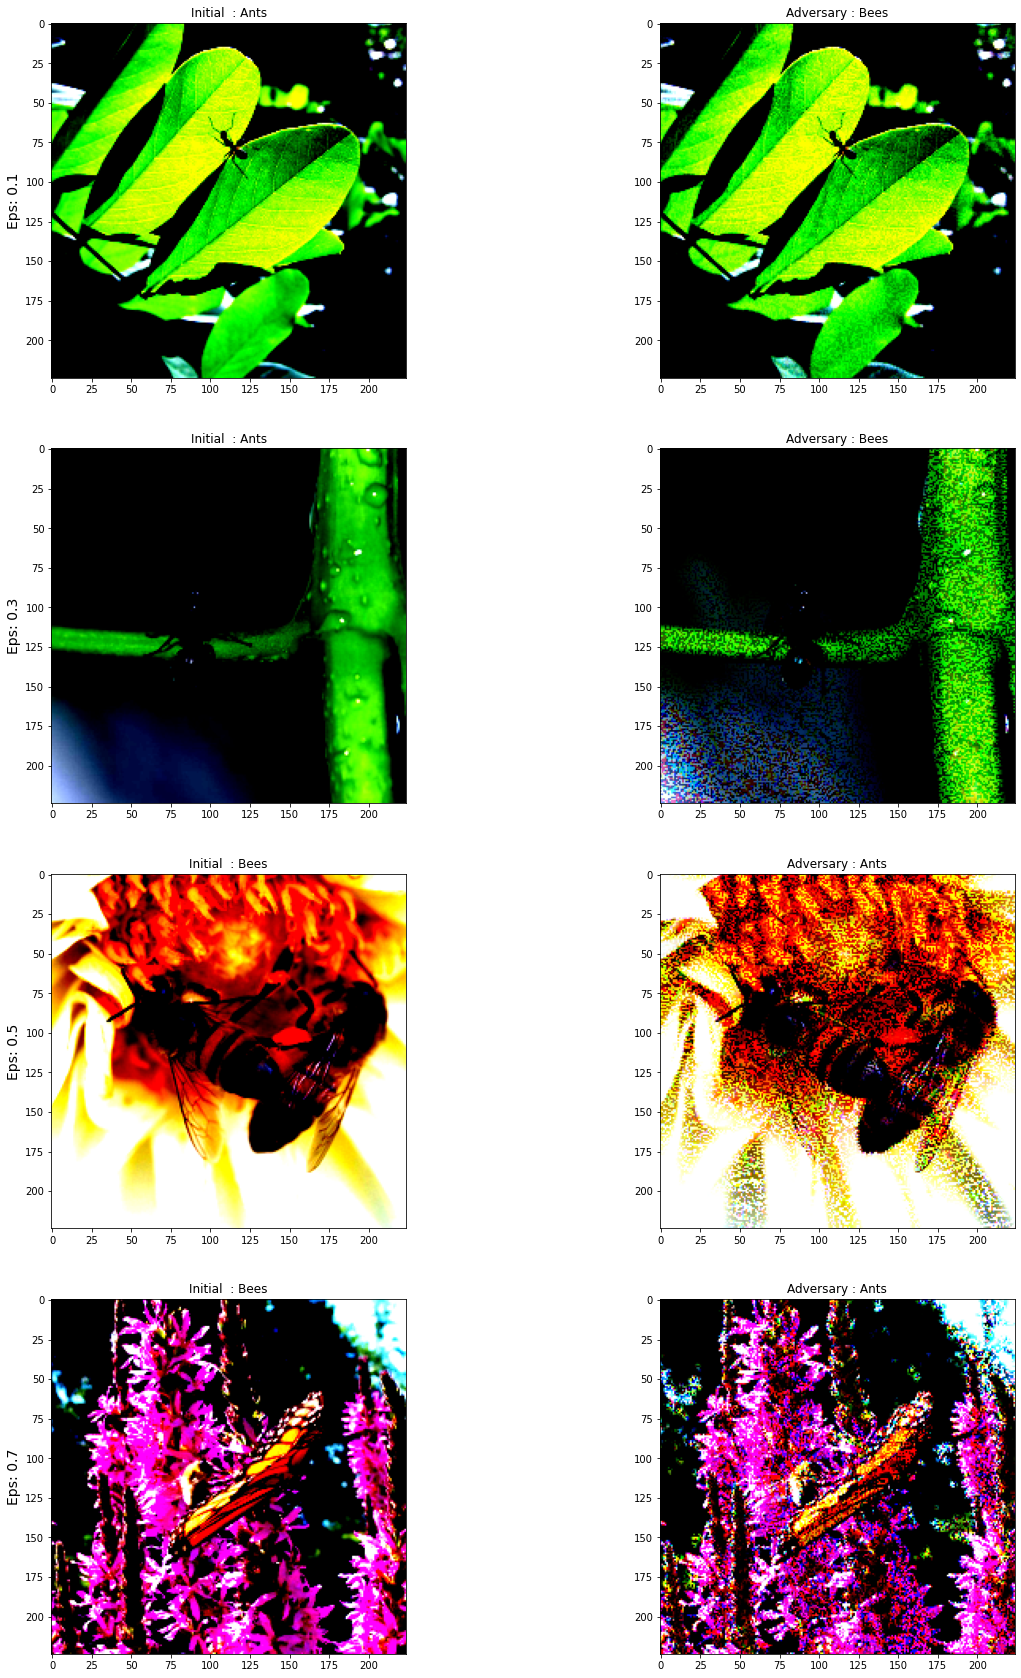

In [292]:
fig , axs = plt.subplots(nrows=len(epsilons), ncols=2,figsize=(20,30))

for i , eps in enumerate(epsilons):
    original, adversary, init_pred , final_pred = examples[i][0]
    axs[i, 0].imshow(original)
    axs[i,0].set_ylabel("Eps: {}".format(eps), fontsize=14)
    axs[i, 0].set_title('Initial  : {}'.format(name_classes[init_pred.item()]))
    axs[i, 1].imshow(adversary)
    axs[i, 1].set_title('Adversary : {}'.format(name_classes[final_pred.item()]))

In [305]:
def validation(model, testloader, device):
    correct = 0
    model.eval()
    for inputs, label in tqdm(testloader):
        inputs = inputs.to(device)
        output = model(inputs)
        final_pred = output.max(1, keepdim=True)[1] 
        if final_pred.item() == label.item(): 
             correct += 1 
    accuracy = correct/ float(len(testloader))
    return accuracy

In [306]:
acc = validation(model_ft, testloader,device)

100%|██████████| 153/153 [00:27<00:00,  5.64it/s]


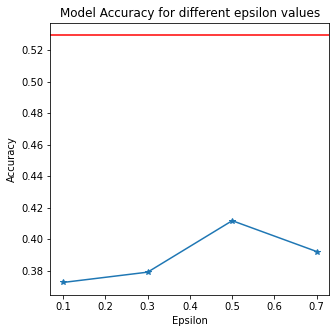

In [321]:
import seaborn as sns 
fig, ax = plt.subplots(figsize=(5,5))
ax.plot(epsilons, accuracies, "*-")
plt.axhline(y=acc,color='r')
plt.title("Model Accuracy for different epsilon values")
plt.xlabel("Epsilon")
plt.ylabel("Accuracy")
plt.show()